In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu

In [2]:
data_path = '../SourceData/Supplementary_Figure9/'

In [3]:
st_ad = sc.read_h5ad(data_path + 'st_ad_all.h5ad')

# Violin plot using the st_ad

In [4]:
st_ad_cm = st_ad.copy()
st_ad_cm = st_ad_cm[st_ad_cm.obs['cell_type'].isin(['CM_s1', 'CM_s2', 'CM_s3'])]

In [5]:
gene_expression = pd.DataFrame(st_ad_cm.X, index=st_ad_cm.obs.index, columns=st_ad_cm.var_names)
cell_types = st_ad_cm.obs['cell_type']

Available genes in AnnData: ['PDK1', 'HAND2', 'PDGFD', 'VEGFA', 'NRP1', 'KCNE2', 'KCND3', 'KCNA4', 'PIEZO1', 'VCL', 'ITGA5', 'ITGB5', 'CDH2', 'GJA1', 'GJA5', 'TNNT2', 'MYH7', 'TNNI3', 'MYL7', 'HEY2']


/var/folders/qc/my6pktfj2x37y67dq8r1g28c0000gn/T/ipykernel_39155/2668497527.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_expression_marker['Cell_Type'] = cell_types


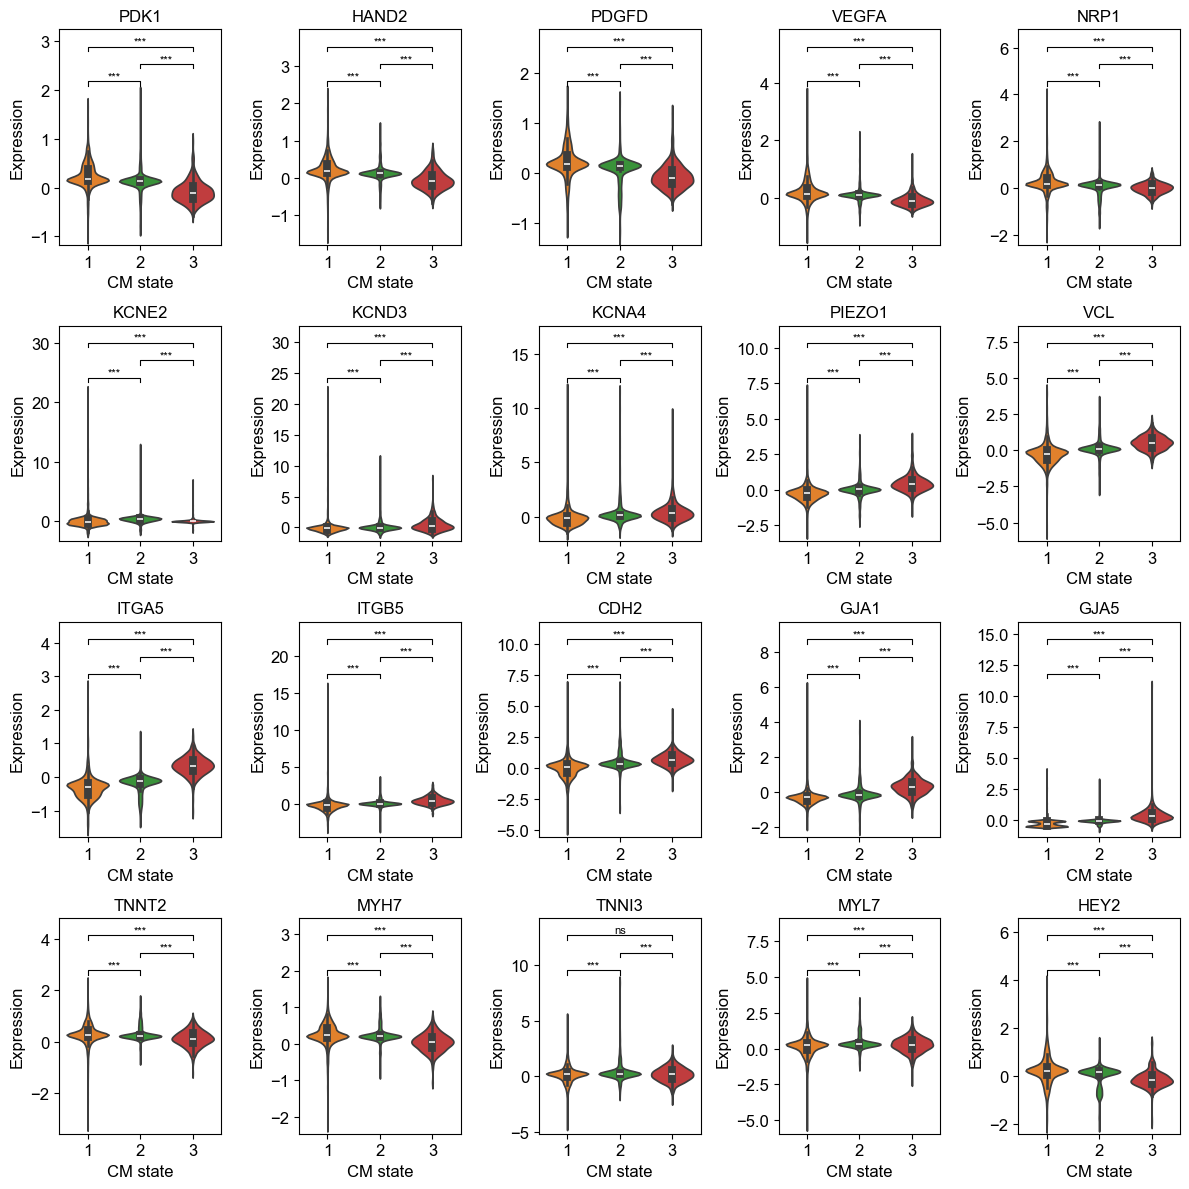

In [6]:
markers = [
    'PDK1', 'HAND2', 'PDGFD', 'VEGFA', 'NRP1', 
    'KCNE2', 'KCND3', 'KCNA4','PIEZO1', #Ion channels 
    'VCL', 'ITGA5', 'ITGB5', 'CDH2', 'GJA1','GJA5',
    'TNNT2', 'MYH7', 'TNNI3', 'MYL7', 'HEY2'
    ]

palette = {'1': '#ff7f0e', '2': '#2ca02c', '3': '#d62728'}

available_genes = [gene for gene in markers if gene in st_ad_cm.var_names]
missing_genes = set(markers) - set(available_genes)

print(f"Available genes in AnnData: {available_genes}")
if missing_genes:
    print(f"Missing genes: {missing_genes}")

if not available_genes:
    raise ValueError("None of the genes in gene_sets are present in the AnnData object")


gene_expression_marker = gene_expression[available_genes]

gene_expression_marker['Cell_Type'] = cell_types

num_features = len(available_genes)
ncols = 5
nrows = (num_features + ncols - 1) // ncols 

plt.rcParams['font.family'] = 'Arial'  

plt.figure(figsize=(12, nrows * 3))

def format_pvalue(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

for i, feature in enumerate(available_genes):
    ax = plt.subplot(nrows, ncols, i + 1) 
    temp_df = pd.DataFrame({
        'Expression': gene_expression_marker[feature],
        'Cell_Type': st_ad_cm.obs['cell_type'].map({'CM_s1': '1', 'CM_s2': '2', 'CM_s3': '3'}),
        'Condition': st_ad_cm.obs['condition'],

    })
    
    sns.violinplot(x='Cell_Type', y='Expression', data=temp_df, hue='Cell_Type',palette=palette, split=False)
    
    group1 = temp_df[temp_df['Cell_Type'] == '1']['Expression']
    group2 = temp_df[temp_df['Cell_Type'] == '2']['Expression']
    group3 = temp_df[temp_df['Cell_Type'] == '3']['Expression']
    
    _, p_12 = mannwhitneyu(group1, group2, alternative='two-sided')
    _, p_13 = mannwhitneyu(group1, group3, alternative='two-sided')
    _, p_23 = mannwhitneyu(group2, group3, alternative='two-sided')
    
    y_max = temp_df['Expression'].max()
    y_range = temp_df['Expression'].max() - temp_df['Expression'].min()
    
    annotation_height = y_max + y_range * 0.05
    line_height = y_range * 0.03
    
    ax.plot([0, 0, 1, 1], [annotation_height, annotation_height + line_height, annotation_height + line_height, annotation_height], 'k-', lw=0.8)
    ax.text(0.5, annotation_height + line_height, format_pvalue(p_12), ha='center', va='bottom', fontsize=8)
    
    annotation_height2 = annotation_height + y_range * 0.12
    ax.plot([1, 1, 2, 2], [annotation_height2, annotation_height2 + line_height, annotation_height2 + line_height, annotation_height2], 'k-', lw=0.8)
    ax.text(1.5, annotation_height2 + line_height, format_pvalue(p_23), ha='center', va='bottom', fontsize=8)
    
    annotation_height3 = annotation_height2 + y_range * 0.12
    ax.plot([0, 0, 2, 2], [annotation_height3, annotation_height3 + line_height, annotation_height3 + line_height, annotation_height3], 'k-', lw=0.8)
    ax.text(1, annotation_height3 + line_height, format_pvalue(p_13), ha='center', va='bottom', fontsize=8)
    
    ax.set_ylim(temp_df['Expression'].min() - y_range * 0.05, annotation_height3 + y_range * 0.15)
    
    plt.title(f'{feature}', fontsize=12)
    plt.xlabel('CM state', fontsize=12)  
    plt.ylabel('Expression', fontsize=12)  
    plt.xticks(fontsize=12)  
    plt.yticks(fontsize=12)  

plt.tight_layout()
plt.show()